In [40]:
# Setup environment
%run 0-Environment_Setup.ipynb

Stored 's3_datalake_path_csv' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


In [41]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape, Normalization, Flatten, Dropout 
from tensorflow.keras.layers import Concatenate, GaussianNoise, Lambda
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, RNN, GRU, Conv1D, MaxPooling1D
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [43]:
# Create a temporary directory for saving data
local_path = f"{os.getcwd()}/tmp"
if not os.path.exists(local_path):
    os.makedirs(local_path)

In [44]:
# Set session variables
from sagemaker.tensorflow import TensorFlow

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_session.region_name
bucket = sess.default_bucket()

train_prefix = "store-sales-forecasting/train"
test_prefix = "store-sales-forecasting/test"
val_prefix = "store-sales-forecasting/val"

In [45]:
# Load data splits for testing in notebook
sagemaker_session.download_data(path=local_path, bucket=bucket, key_prefix=train_prefix)
sagemaker_session.download_data(path=local_path, bucket=bucket, key_prefix=test_prefix)
sagemaker_session.download_data(path=local_path, bucket=bucket, key_prefix=val_prefix)

train_inputs = np.load(os.path.join(local_path, 'train_inputs.npy'))
train_targets = np.load(os.path.join(local_path, 'train_targets.npy'))

test_inputs = np.load(os.path.join(local_path, 'test_inputs.npy'))
test_targets = np.load(os.path.join(local_path, 'test_targets.npy'))

val_inputs =  np.load(os.path.join(local_path, 'val_inputs.npy'))
val_targets = np.load(os.path.join(local_path, 'val_targets.npy'))

global_mean = np.load(os.path.join(local_path, 'global_mean.npy'))
global_stddev = np.load(os.path.join(local_path, 'global_stddev.npy'))

print(train_inputs.shape)
print(train_targets.shape)
print(test_inputs.shape)
print(test_targets.shape)
print(val_inputs.shape)
print(val_targets.shape)
print(global_mean)
print(global_stddev)

(1340, 54, 7, 18)
(1340, 54, 1)
(161, 54, 7, 18)
(161, 54, 1)
(162, 54, 7, 18)
(162, 54, 1)
[11066.08424029    72.62890566    23.37328494]
[9928.63142484   26.6484683    43.2551771 ]


In [ ]:
# Prepare validation data for batch transform job
import json

with open(f"{local_path}/validation_data.ndjson", "w") as f:
    for i, window in enumerate(val_inputs):
        instance = {"input_1": window.tolist()}
        json_line = json.dumps(instance)
        if i < len(val_inputs) - 1:
            f.write(json_line + "\n")
        else:
            f.write(json_line)
        
    
sagemaker_session.upload_data(f"{local_path}/validation_data.ndjson", bucket=bucket, key_prefix=transform_input_prefix)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 54, 7, 18)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 378, 18)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 54)             │           486 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 54, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,350 (5.27 KB)

 Trainable params: 1,350 (5.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.8872 - mean_absolute_error: 0.6100 - root_mean_squared_error: 0.9217 - val_loss: 0.7577 - val_mean_absolute_error: 0.5378 - val_root_mean_squared_error: 0.8624
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.4555 - mean_absolute_error: 0.4163 - root_mean_squared_error: 0.6644 - val_loss: 0.5878 - val_mean_absolute_error: 0.4796 - val_root_mean_squared_error: 0.7602
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.3654 - mean_absolute_error: 0.3660 - root_mean_squared_error: 0.5956 - val_loss: 0.5064 - val_mean_absolute_error: 0.4464 - val_root_mean_squared_error: 0.7047
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.3646 - mean_absolute_error: 0.3704 - root_mean_squared_error: 0.5919 - val_loss: 0.4843 - val_mean_absolute_error: 0.4331 - val_root_mean_squared_error: 0.6883
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.3388 - mean_absolute_error: 0.3646 - roo

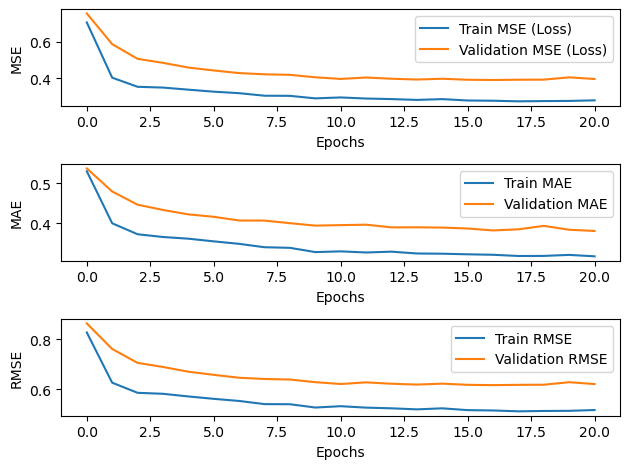

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4334 - mean_absolute_error: 0.3769 - root_mean_squared_error: 0.6442


In [47]:
# LSTM model
lstm_es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    restore_best_weights=True
)

input_layer = Input(shape=train_inputs.shape[1:])
reshaped_input = Reshape(target_shape=(-1, train_inputs.shape[3]))(input_layer)
lstm = LSTM(8, kernel_regularizer=tf.keras.regularizers.l2(0.002))(reshaped_input)
dropout = Dropout(0.2)(lstm)
dense = Dense(train_targets.shape[1] * train_targets.shape[2])(dropout)
outputs = Reshape(target_shape=(train_targets.shape[1], train_targets.shape[2]))(dense)

lstm_model = Model(inputs=input_layer, outputs=outputs)

lstm_model.compile(
    loss='mean_squared_error', 
    metrics=['root_mean_squared_error', 'mean_absolute_error'], 
    optimizer=tf.keras.optimizers.Adam(0.002)
)

print(lstm_model.summary())


history = lstm_model.fit(
    train_inputs, 
    train_targets, 
    validation_data=(test_inputs, test_targets), 
    epochs=50, 
    batch_size=10, 
    callbacks=[lstm_es_callback]
)

fig, axs = plt.subplots(3)
axs[0].plot(history.history['loss'], label='Train MSE (Loss)')
axs[0].plot(history.history['val_loss'], label='Validation MSE (Loss)')
axs[1].plot(history.history['mean_absolute_error'], label='Train MAE')
axs[1].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axs[2].plot(history.history['root_mean_squared_error'], label='Train RMSE')
axs[2].plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')

axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('RMSE')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.tight_layout()
plt.show()

eval = lstm_model.evaluate(val_inputs, val_targets)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 54, 7, 18)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 378, 18)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 378, 32)        │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 189, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 189, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 8)              │         1,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 54)             │           486 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 54, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,254 (12.71 KB)

 Trainable params: 3,254 (12.71 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.9198 - mean_absolute_error: 0.6098 - root_mean_squared_error: 0.9160 - val_loss: 0.7007 - val_mean_absolute_error: 0.4988 - val_root_mean_squared_error: 0.8214
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.3965 - mean_absolute_error: 0.3898 - root_mean_squared_error: 0.6116 - val_loss: 0.4994 - val_mean_absolute_error: 0.4321 - val_root_mean_squared_error: 0.6966
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.2882 - mean_absolute_error: 0.3425 - root_mean_squared_error: 0.5236 - val_loss: 0.4366 - val_mean_absolute_error: 0.4154 - val_root_mean_squared_error: 0.6519
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.3362 - mean_absolute_error: 0.3529 - root_mean_squared_error: 0.5693 - val_loss: 0.4108 - val_mean_absolute_error: 0.3975 - val_root_mean_squared_error: 0.6335
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.2657 - mean_absolute_error: 0.3269 - roo

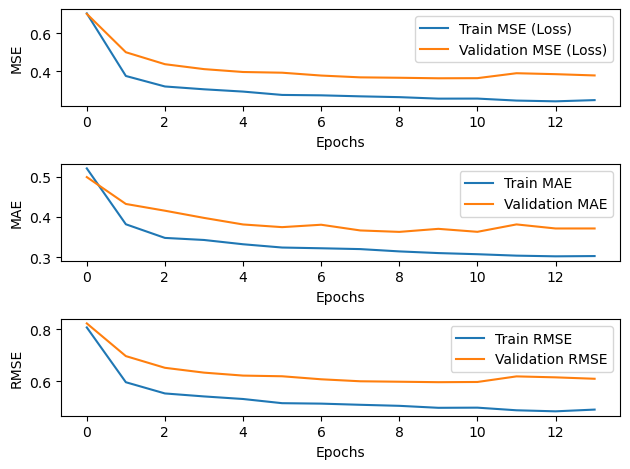

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4011 - mean_absolute_error: 0.3573 - root_mean_squared_error: 0.6219


In [48]:
# CNN-GRU model
gru_es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    restore_best_weights=True
)

input_layer = Input(shape=train_inputs.shape[1:])
reshaped_input = Reshape(target_shape=(-1, train_inputs.shape[3]))(input_layer)
conv = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(reshaped_input)
pooled = MaxPooling1D(pool_size=2)(conv)
dropout1 = Dropout(0.1)(pooled)
gru = GRU(8, kernel_regularizer=tf.keras.regularizers.l2(0.004))(dropout1)
dropout2 = Dropout(0.2)(gru)
dense = Dense(train_targets.shape[1] * train_targets.shape[2])(dropout2)
outputs = Reshape(target_shape=(train_targets.shape[1], train_targets.shape[2]))(dense)

gru_model = Model(inputs=input_layer, outputs=outputs)

gru_model.compile(
    loss='mean_squared_error', 
    metrics=['root_mean_squared_error', 'mean_absolute_error'], 
    optimizer=tf.keras.optimizers.Adam(0.002)
)

print(gru_model.summary())


history = gru_model.fit(
    train_inputs, 
    train_targets, 
    validation_data=(test_inputs, test_targets), 
    epochs=50, 
    batch_size=10, 
    callbacks=[gru_es_callback]
)

fig, axs = plt.subplots(3)
axs[0].plot(history.history['loss'], label='Train MSE (Loss)')
axs[0].plot(history.history['val_loss'], label='Validation MSE (Loss)')
axs[1].plot(history.history['mean_absolute_error'], label='Train MAE')
axs[1].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axs[2].plot(history.history['root_mean_squared_error'], label='Train RMSE')
axs[2].plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')

axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('RMSE')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.tight_layout()
plt.show()

eval = gru_model.evaluate(val_inputs, val_targets)

In [50]:
# Generate predicitons for the validation set
predictions = gru_model.predict(val_inputs)

# Denormalize to the original scale of the data
targets_denormalized = val_targets * global_stddev[0] + global_mean[0]
predictions_denormalized = predictions * global_stddev[0] + global_mean[0]

targets_flat = targets_denormalized.flatten()
predictions_flat = predictions_denormalized.flatten()

# Join the predictions and actual sales values for each store/date into a dataframe
n = predictions_denormalized.shape[0]
store_numbers = list(range(54)) * n
predictions_df = pd.DataFrame({'store_nbr': store_numbers, 'actual_sales': targets_flat, 'predicted_sales': predictions_flat})

# View a random sample of 20 predicted vs actual sales values
display(predictions_df.sample(20))

# Compute RMSE and MAE on the original scale
rmse = root_mean_squared_error(targets_flat, predictions_flat)
mae = mean_absolute_error(targets_flat, predictions_flat)
print(f"RMSE: {rmse} MAE: {mae}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


store_nbr  actual_sales  predicted_sales
3121         43  47788.349307     43947.328125
7286         50  27004.259530     23726.916016
4686         42  14143.641230     10686.080078
6504         24   9707.761624      8440.600586
5277         39  12939.943359     14603.056641
1272         30  12802.052511     11300.363281
3758         32  11790.511877     11648.965820
3139          7  19037.501988     22669.066406
7692         24   9531.841457      7586.380859
2709          9   3990.910891      6322.883301
4620         30  12019.176735     12693.855469
3151         19  14099.489324     13966.182617
4339         19  17516.119837     14386.816406
332           8  19002.327948     18174.525391
8363         47  17292.871824     19077.839844
4047         51  25643.492072       291.586914
8199         45  41567.974613     38401.121094
1679          5  16423.200068     17780.675781
3819         39  22360.388507     14020.074219
5559         51  30354.359767       450.603516

RMSE: 6813.44415118184 MAE: 3675.389964039716


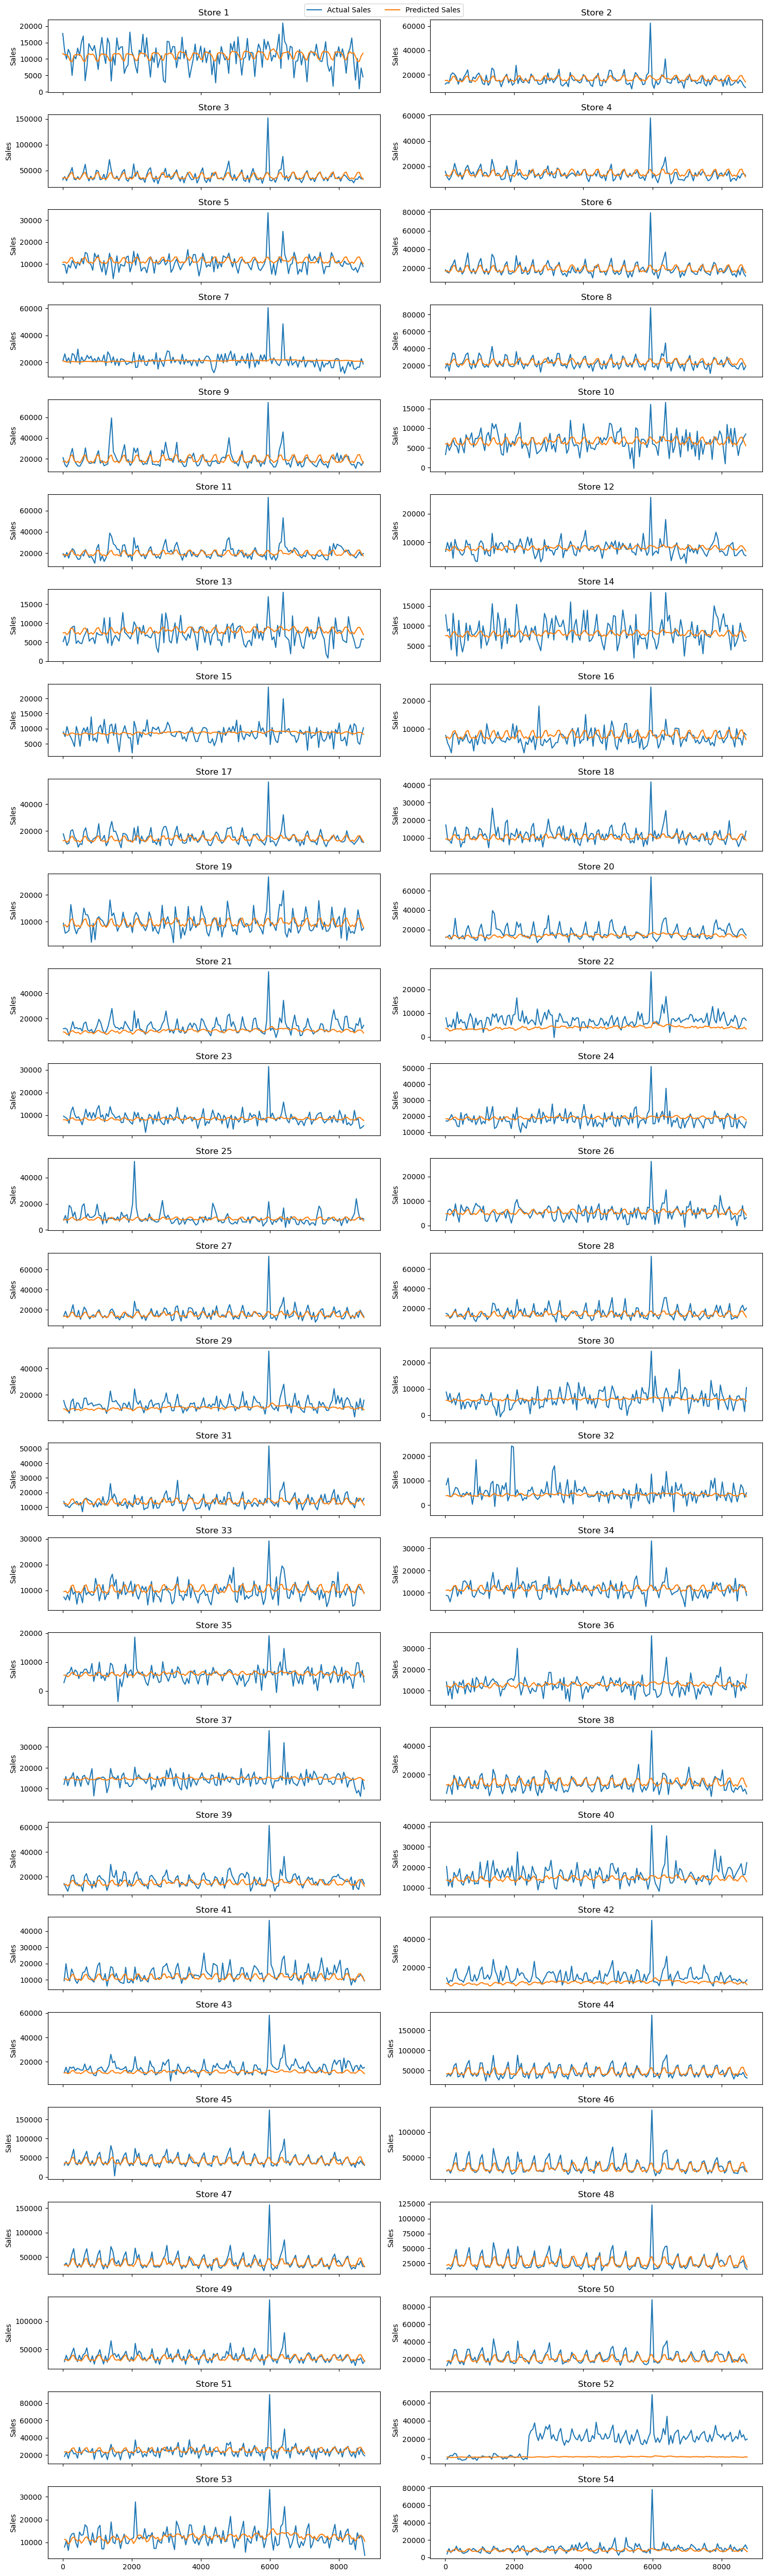

In [51]:
fig, axs = plt.subplots(27, 2, figsize=(15, 50), sharex=True)
axs = axs.ravel()
for i in range(54):
    ax = axs[i]
    store_data = predictions_df[predictions_df["store_nbr"] == i]

    ax.plot(store_data.index, store_data['actual_sales'], label='Actual Sales')
    ax.plot(store_data.index, store_data['predicted_sales'], label='Predicted Sales')

    ax.set_title(f"Store {i+1}")
    ax.set_ylabel("Sales")

fig.legend(['Actual Sales', 'Predicted Sales'], loc='upper center', ncol=2)
plt.tight_layout()
plt.show()

## Experiment: Train a model on the residuals for each store

In [52]:
!pip install xgboost

  Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.23.4-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)
Using cached nvidia_nccl_cu12-2.23.4-py3-none-manylinux2014_x86_64.whl (199.0 MB)


In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor

In [101]:
# Generate predictions from the training set and calculate residuals (error) 
train_predictions = gru_model.predict(train_inputs)
train_residuals = train_targets - train_predictions

lag_continuous_features = continuous_train_inputs[:, :, -1, :3]
rolling_mean_continuous_features = np.mean(train_inputs[:, :, :, :3], axis=2)
rolling_std_continuous_features = np.std(train_inputs[:, :, :, :3], axis=2)
latest_categorical_features = train_inputs[:, :, -1, 3:]

combined_train_features = np.concatenate(
    [lag_continuous_features, rolling_mean_continuous_features, 
     rolling_std_continuous_features, latest_categorical_features], axis=-1
)

# # Join the inputs back together
# train_inputs = np.concatenate((continuous_train_inputs, categorical_train_inputs), axis=-1)
# print(train_inputs.shape)

# # Aggregate the days in each window
# aggregated_train_inputs = np.mean(train_inputs, axis=2)

print(train_predictions.shape)
print(train_residuals.shape)
print(combined_train_features.shape)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
(1340, 54, 1)
(1340, 54, 1)
(1340, 54, 24)


In [102]:
# For each store, train a random forest regressor on the residuals
store_residual_models = {}
n_estimators_per_tree = 20

for i in range(54):
    store_train_inputs = combined_train_features[:, i, :]
    store_train_residuals = train_residuals[:, i]

    #store_residual_model = RandomForestRegressor(n_estimators=n_estimators_per_tree)
    store_residual_model = GradientBoostingRegressor(loss='absolute_error', n_estimators=n_estimators_per_tree)
    #store_residual_model = DecisionTreeRegressor()
    #store_residual_model = AdaBoostRegressor(n_estimators=n_estimators_per_tree, loss='square', learning_rate=0.5)
    #store_residual_model = HistGradientBoostingRegressor(learning_rate=0.2)
    #store_residual_model = XGBRegressor(n_estimators=n_estimators_per_tree, early_stopping_rounds=4, learning_rate=0.5, gamma=0.1)
    #store_residual_model = XGBRegressor(n_estimators=n_estimators_per_tree)
    store_residual_model.fit(store_train_inputs, store_train_residuals.squeeze())#, eval_set=[(store_train_inputs, store_train_residuals)], verbose=0)

    store_residual_models[i] = store_residual_model


store_residual_models[0]

GradientBoostingRegressor(loss='absolute_error', n_estimators=20)

In [103]:
# Generate predictions and residuals for the validation set
val_predictions = gru_model.predict(val_inputs)
val_residuals = val_targets - val_predictions

# # Join the inputs back together
# val_inputs = np.concatenate((continuous_val_inputs, categorical_val_inputs), axis=-1)
# print(val_inputs.shape)

# # Aggregate across days
# aggregated_val_inputs = np.mean(val_inputs, axis=2)

# print(val_predictions.shape)
# print(val_residuals.shape)
# print(aggregated_val_inputs.shape)

lag_continuous_features = val_inputs[:, :, -1, :3]
rolling_mean_continuous_features = np.mean(val_inputs[:, :, :, :3], axis=2)
rolling_std_continuous_features = np.std(val_inputs[:, :, :, :3], axis=2)
latest_categorical_features = val_inputs[:, :, -1, 3:]

combined_val_features = np.concatenate(
    [lag_continuous_features, rolling_mean_continuous_features, 
     rolling_std_continuous_features, latest_categorical_features], axis=-1
)

# Set a placeholder for the residual tree predictions
residual_model_predictions = np.zeros((val_residuals.shape[0], val_residuals.shape[1]))

# For each store, use the tree trained on the errors for that store to correct model predictions
for i in range(54):
    store_val_inputs = combined_val_features[:, i, :]
    store_predictions = store_residual_models[i].predict(store_val_inputs)
    residual_model_predictions[:, i] = store_predictions

print(residual_model_predictions.shape)

# Correct the original model predictions
ensemble_predictions = val_predictions.squeeze() + residual_model_predictions

# Denormalize the true targets and predictions
val_targets_denormalized = val_targets * global_stddev[0] + global_mean[0]
ensemble_predictions_denormalized = ensemble_predictions * global_stddev[0] + global_mean[0]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(162, 54)


In [104]:
val_targets_flat = val_targets_denormalized.flatten()
ensemble_predictions_flat = ensemble_predictions_denormalized.flatten()

# Join the predictions and actual sales values for each store/date into a dataframe
n = ensemble_predictions_denormalized.shape[0]
store_numbers = list(range(54)) * n
predictions_df = pd.DataFrame({'store_nbr': store_numbers, 'actual_sales': val_targets_flat, 'predicted_sales': ensemble_predictions_flat})

# View a random sample of 20 predicted vs actual sales values
display(predictions_df.sample(20))

# Compute RMSE and MAE on the original scale
rmse = root_mean_squared_error(val_targets_flat, ensemble_predictions_flat)
mae = mean_absolute_error(val_targets_flat, ensemble_predictions_flat)
print(f"RMSE: {rmse} MAE: {mae}")

store_nbr  actual_sales  predicted_sales
627          33  14222.401845     13966.985805
3623          5  14774.343049     21092.979874
7344          0  14519.662043     12190.910297
1018         46  55143.190523     44953.248697
8451         27  10386.004669     10246.897381
7845         15   7746.244112      7380.149634
281          11  11063.640189      8335.232348
5796         18   5390.016834      7469.347883
1136          2  33321.185277     30822.423320
326           2  33455.177131     35873.612701
58            4   9633.547031      9951.377136
7202         20  11169.506467     12937.493075
2654          8  14727.647098     15232.956206
8589          3  14030.193643     17039.703654
2912         50  26846.169896     27245.166345
5652         36  12804.136976     13595.127349
3418         16  17999.545275     13416.060584
1951          7  18411.426971     22035.191855
7392         48  36240.833230     33288.215261
3532         22  10068.022165      7290.205143

RMSE: 6617.856469373364 MAE: 3411.4719594397684


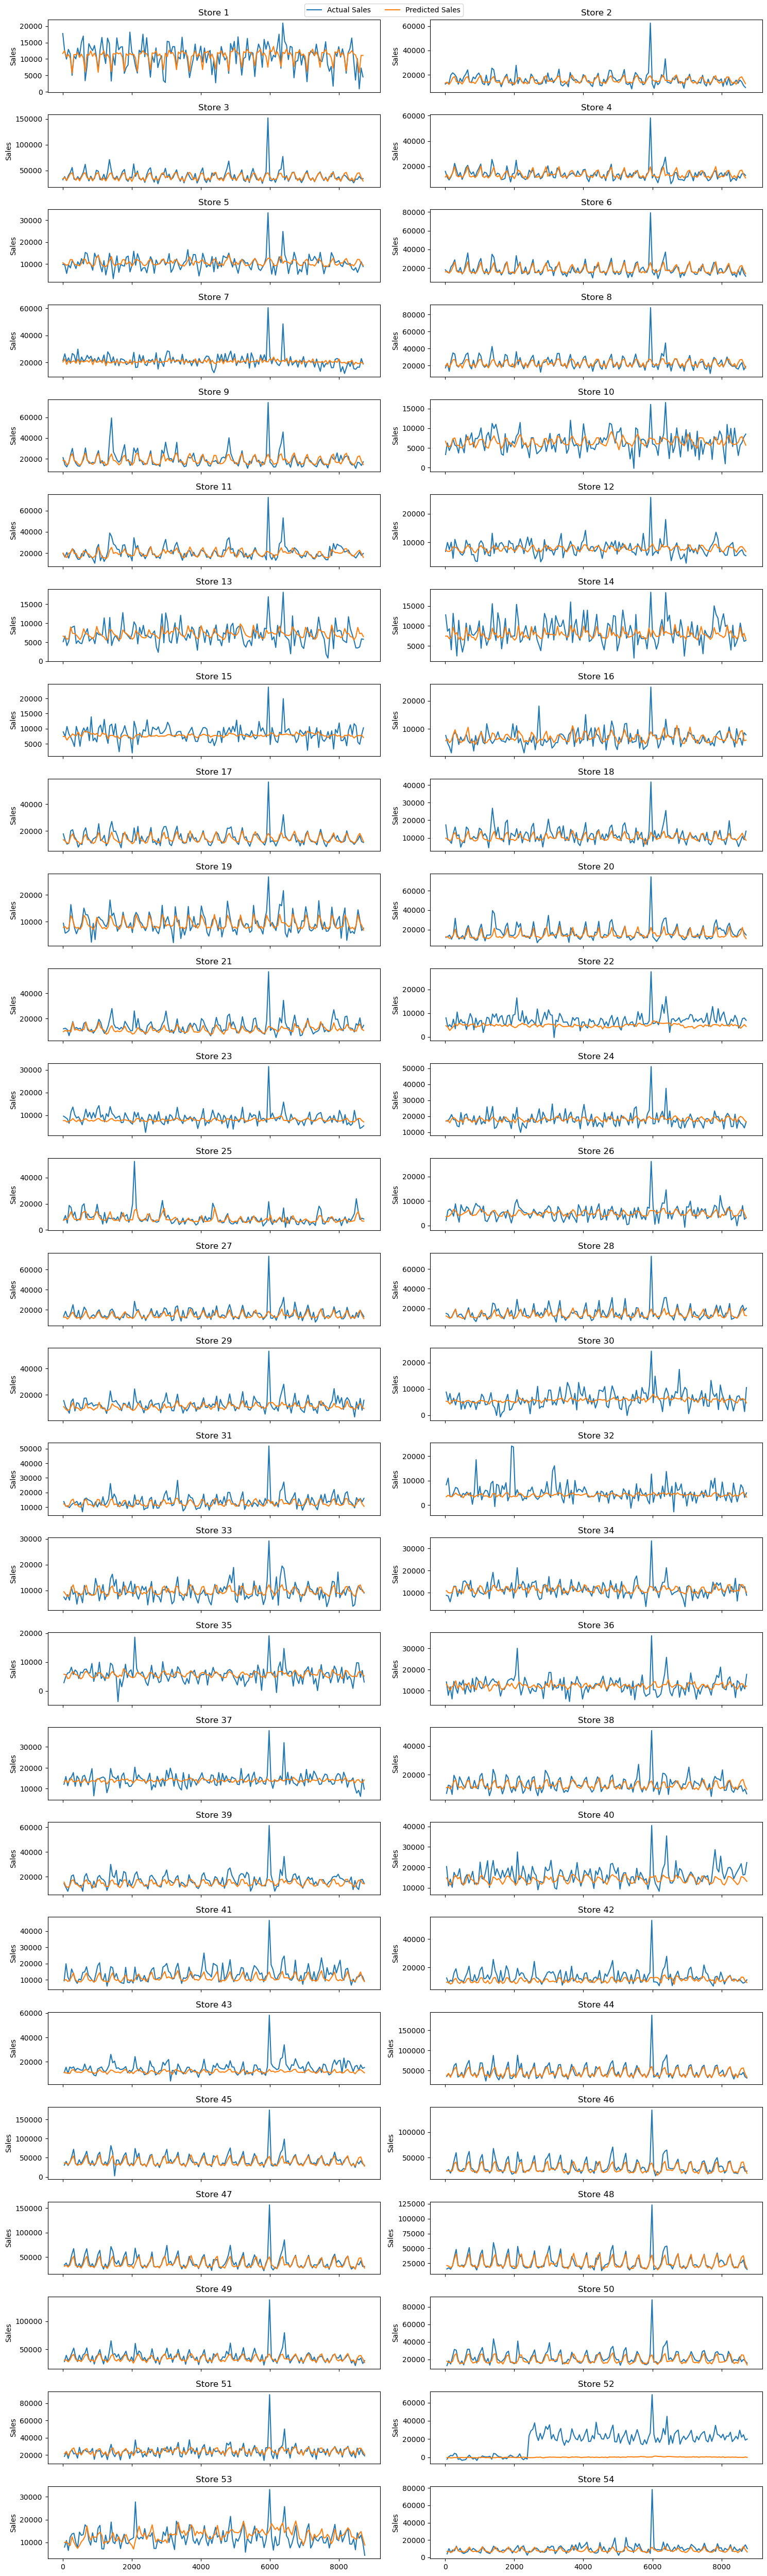

In [105]:
fig, axs = plt.subplots(27, 2, figsize=(15, 50), sharex=True)
axs = axs.ravel()
for i in range(54):
    ax = axs[i]
    store_data = predictions_df[predictions_df["store_nbr"] == i]

    ax.plot(store_data.index, store_data['actual_sales'], label='Actual Sales')
    ax.plot(store_data.index, store_data['predicted_sales'], label='Predicted Sales')

    ax.set_title(f"Store {i+1}")
    ax.set_ylabel("Sales")

fig.legend(['Actual Sales', 'Predicted Sales'], loc='upper center', ncol=2)
plt.tight_layout()
plt.show()

## Estimator

In [106]:
# Test regex for metrics
import re

metric_definitions=[
    {'Name': 'loss', 'Regex': "loss: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'root_mean_squared_error', 'Regex': "root_mean_squared_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'mean_absolute_error', 'Regex': "mean_absolute_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'val_loss', 'Regex': "val_loss: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'val_root_mean_squared_error', 'Regex': "val_root_mean_squared_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'val_mean_absolute_error', 'Regex': "val_mean_absolute_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "Epoch ([0-9]+(.|e\-)[0-9]+),?"}]

txt = "Epoch 134/134 - 11s - loss: 0.3353 - root_mean_squared_error: 0.5661 - mean_absolute_error: 0.3318 - val_loss: 0.4673 - val_root_mean_squared_error: 0.6754 - val_mean_absolute_error: 0.3939"
for metric in metric_definitions:
    for name, regex in metric.items():
        if name == "Regex":
            print(regex)
            print(re.search(regex, txt))


loss: ([0-9]+(.|e\-)[0-9]+),?
<re.Match object; span=(22, 34), match='loss: 0.3353'>
root_mean_squared_error: ([0-9]+(.|e\-)[0-9]+),?
<re.Match object; span=(37, 68), match='root_mean_squared_error: 0.5661'>
mean_absolute_error: ([0-9]+(.|e\-)[0-9]+),?
<re.Match object; span=(71, 98), match='mean_absolute_error: 0.3318'>
val_loss: ([0-9]+(.|e\-)[0-9]+),?
<re.Match object; span=(101, 117), match='val_loss: 0.4673'>
val_root_mean_squared_error: ([0-9]+(.|e\-)[0-9]+),?
<re.Match object; span=(120, 155), match='val_root_mean_squared_error: 0.6754'>
val_mean_absolute_error: ([0-9]+(.|e\-)[0-9]+),?
<re.Match object; span=(158, 189), match='val_mean_absolute_error: 0.3939'>
Epoch ([0-9]+(.|e\-)[0-9]+),?
<re.Match object; span=(0, 13), match='Epoch 134/134'>


In [113]:
# Define regex patterns for capturing training metrics
metric_definitions=[
    {'Name': 'loss', 'Regex': "loss: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'root_mean_squared_error', 'Regex': "root_mean_squared_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'mean_absolute_error', 'Regex': "mean_absolute_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'val_loss', 'Regex': "val_loss: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'val_root_mean_squared_error', 'Regex': "val_root_mean_squared_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'val_mean_absolute_error', 'Regex': "val_mean_absolute_error: ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "Epoch ([0-9]+(.|e\-)[0-9]+),?"}]

# Define an estimator using the TensorFlow container and custom training logic
estimator = TensorFlow(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='2.6',
    py_version='py38',
    hyperparameters={
        'batch_size': 10,
        'epochs': 50,
        'learning_rate': 0.002,
        'l2_regularization': 0.004,
        'dropout': 0.1
    },
    metric_definitions=metric_definitions,
    output_path=f's3://{sagemaker_session.default_bucket()}/store-sales-forecasting/training-output/'
)

# Fit the model
estimator.fit({
    'train': f"s3://{sagemaker_session.default_bucket()}/{train_prefix}", 
    'test':  f"s3://{sagemaker_session.default_bucket()}/{test_prefix}", 
    'validation':  f"s3://{sagemaker_session.default_bucket()}/{val_prefix}"
})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2024-10-15-03-19-28-275


2024-10-15 03:19:28 Starting - Starting the training job...
2024-10-15 03:19:43 Starting - Preparing the instances for training...
2024-10-15 03:20:26 Downloading - Downloading the training image......
2024-10-15 03:21:16 Training - Training image download completed. Training in progress..2024-10-15 03:21:27.437216: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-10-15 03:21:27.437380: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-10-15 03:21:27.463837: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-10-15 03:21:28,639 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2024-10-15 03:21:28,647 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-15 

In [157]:
from sagemaker.tuner import ContinuousParameter, IntegerParameter
from sagemaker.tuner import HyperparameterTuner

# Define an estimator for hyperparameter tuning
hp_tuner_estimator = TensorFlow(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='2.6',
    py_version='py38',
    hyperparameters={
        'batch_size': 10,
        'epochs': 50,
        'learning_rate': 0.002,
        'l2_regularization': 0.004,
        'dropout': 0.1
    },
    metric_definitions=metric_definitions,
    output_path=f's3://{sagemaker_session.default_bucket()}/store-sales-forecasting/training-output/'
)

# Define hyperparameter ranges to test
hyperparameter_ranges = {
    "batch_size": IntegerParameter(10, 32, scaling_type="Auto"),
    "learning_rate": ContinuousParameter(0.001, 0.01, scaling_type="Auto"),
    "l2_regularization": ContinuousParameter(0.001, 0.01, scaling_type="Auto"),
    "dropout": ContinuousParameter(0.0, 0.5, scaling_type="Auto")
}

# Define tuner
hp_tuner = HyperparameterTuner(
    hp_tuner_estimator,
    objective_metric_name="val_loss",
    objective_type="Minimize",
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions, 
    max_jobs=6,
    max_parallel_jobs=2
)

# Launch a SageMaker Tuning job to search for the best hyperparameters
hp_tuner.fit({
    'train': f"s3://{sagemaker_session.default_bucket()}/{train_prefix}", 
    'test':  f"s3://{sagemaker_session.default_bucket()}/{test_prefix}", 
    'validation':  f"s3://{sagemaker_session.default_bucket()}/{val_prefix}"
})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: tensorflow-training-241015-0522


............................................................................................................!


In [164]:
# Get the description of the most recent tuning job
tuning_job_name = sm_client.list_hyper_parameter_tuning_jobs()['HyperParameterTuningJobSummaries'][0]['HyperParameterTuningJobName']

tuning_job_result = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

tuning_job_result

{'HyperParameterTuningJobName': 'tensorflow-training-241015-0522',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:342408968837:hyper-parameter-tuning-job/tensorflow-training-241015-0522',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'val_loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 4,
   'MaxParallelTrainingJobs': 2},
  'ParameterRanges': {'IntegerParameterRanges': [{'Name': 'batch_size',
     'MinValue': '10',
     'MaxValue': '32',
     'ScalingType': 'Auto'}],
   'ContinuousParameterRanges': [{'Name': 'learning_rate',
     'MinValue': '0.001',
     'MaxValue': '0.01',
     'ScalingType': 'Auto'},
    {'Name': 'l2_regularization',
     'MinValue': '0.001',
     'MaxValue': '0.01',
     'ScalingType': 'Auto'},
    {'Name': 'dropout',
     'MinValue': '0.0',
     'MaxValue': '0.5',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': []},
  'TrainingJobEarlyStoppi

In [167]:
# Save the best hyperparameters from the tuning job
tuned_hyperparameters = tuning_job_result['BestTrainingJob']['TunedHyperParameters']
print(tuned_hyperparameters)

# Define a new estimator using the tuned hyperparameters
tuned_estimator = TensorFlow(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='2.6',
    py_version='py38',
    hyperparameters=tuned_hyperparameters,
    metric_definitions=metric_definitions,
    output_path=f's3://{sagemaker_session.default_bucket()}/store-sales-forecasting/training-output/'
)


{'batch_size': '32', 'dropout': '0.19774064370651157', 'l2_regularization': '0.005657446011379216', 'learning_rate': '0.004155777561588289'}


In [168]:
# Fit the model
tuned_estimator.fit({
    'train': f"s3://{sagemaker_session.default_bucket()}/{train_prefix}", 
    'test':  f"s3://{sagemaker_session.default_bucket()}/{test_prefix}", 
    'validation':  f"s3://{sagemaker_session.default_bucket()}/{val_prefix}"
})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2024-10-15-05-41-38-410


2024-10-15 05:41:38 Starting - Starting the training job...
2024-10-15 05:41:54 Starting - Preparing the instances for training...
2024-10-15 05:42:25 Downloading - Downloading input data...
2024-10-15 05:42:50 Downloading - Downloading the training image.....2024-10-15 05:43:48.218500: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-10-15 05:43:48.218670: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-10-15 05:43:48.245123: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-10-15 05:43:49,366 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2024-10-15 05:43:49,374 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-15 05:43:49,627 sagemaker-trainin

In [174]:
# Print S3 path where model was saved
sm_client = boto3.client('sagemaker', region_name=region)
last_training_job_name = sm_client.list_training_jobs()['TrainingJobSummaries'][0]['TrainingJobName']
model_artifacts = sm.describe_training_job(TrainingJobName=last_training_job_name)['ModelArtifacts']['S3ModelArtifacts']
model_artifacts

's3://sagemaker-us-east-1-342408968837/store-sales-forecasting/training-output/tensorflow-training-2024-10-15-05-41-38-410/output/model.tar.gz'

In [175]:
# Print S3 path where model was saved
sm_client = boto3.client('sagemaker', region_name=region)
model_artifacts = tuned_estimator.latest_training_job.describe()["ModelArtifacts"]["S3ModelArtifacts"]
print(f"Model artifacts saved at: {model_artifacts}")

Model artifacts saved at: s3://sagemaker-us-east-1-342408968837/store-sales-forecasting/training-output/tensorflow-training-2024-10-15-05-41-38-410/output/model.tar.gz


In [176]:
# Create a model from the last training job
model_name = "store-sales-forecasting-custom-model-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model = tuned_estimator.create_model(name=model_name)
model_container = model.prepare_container_def(instance_type='ml.m5.xlarge')

print(model_container)

sagemaker_session.create_model(model_name, role, model_container)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: store-sales-forecasting-custom-model-2024-10-15-05-53-46


{'Image': '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.6-cpu', 'Environment': {'SAGEMAKER_TFS_NGINX_LOGLEVEL': 'info'}, 'ModelDataUrl': 's3://sagemaker-us-east-1-342408968837/store-sales-forecasting/training-output/tensorflow-training-2024-10-15-05-41-38-410/output/model.tar.gz'}


'store-sales-forecasting-custom-model-2024-10-15-05-53-46'